In [510]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Introduction

Tolle et al.[1] constructed a monitoring device called "macroscope" on Californian redwood trees, which is essentially a system of sensor node networks deployed on various locations on the tree that record a group of climate variables over an extended period of time. This provided researchers an unprecedented opportunity to study the microclimate ("a local set of atmospheric conditions that differ from those in the surrounding areas" [2]) around a redwood tree. Previous studies of the the microclimate were only able to obtain "snapshots" of the climate. While with this network of sensor nodes that continuously measures climate variables, we are able to obtain a full spatio-temporal landscape of the microclimate on the redwood tree. This will help us better understand the environmental dynamics around the trees and how they interact with them.

However, since this was the first attempt of setting up such a system, the recording process turned out to be problematic. Sensor were found to report abnormal values. And due to battery life and storage limit, many nodes stopped recording at different time points before the planned end date. These problems has led to poor data quality and present challenges for data analysis. In this report, we will first briefly describe the dataset. Then we will discuss exploratory procedures to identify issues in the data and clean the data. We showcase how data cleaning can affect the result of analysis. And we make use of the spatio-temporal information of the recordings to demonstrate that such data is indeed helpful for studying the microclimate surrounding redwood trees.

# Data

This is a time-series dataset that includes measurements of four climate variables: temperature, humidity, incident PAR and reflected PAR (photosynthetically active radiation, which represents energy available for photosynthesis and also indicates the overall strength of sunlight). The data were recorded with a time interval of 5 minutes from April 27th to June 10th 2004, 44 days in total. And they were measured by 73 sensor nodes located on different heights of two redwood trees. The spatial distance between nodes are about 2 meters. The nodes are also placed on different sides of the tree, with the majority on the west side and some on the east side. This resulted in totally 416,036 measurements of the four variables respectively.

## Data Collection & Cleaning

The data were collected by specially designed sensor nodes. Each sensor node is hat-shaped. One the top there is the sensor for measuring incident PAR and therefore receiving sunlight from above. At the bottom we have the sensors for temperature, humidity and reflected PAR. This is to prevent the sensor from being affected by direct sunlight and other environmental disturbances such as wind and rain. The temperature and humidity were measured by the Sensirion SHT11 digital sensor in Celsius (± 0.5°C) and relative humidity (± 3.5%). The incident and reflected PAR were measured by two Hamamatsu S1087 photodiodes in $\mu$mol/m/s. These sensor nodes form a network and the data were transmitted to a recording system. Also each sensor has as data logger that stores the measurement data locally. Finally the data were retrieved in both ways.

In [422]:
## import & concat out three housing datasets
path = '/Users/andrewma/Desktop/Stat-Notes/data/'
df = pd.concat(map(pd.read_csv, [path + 'texas_counties1.csv', path + 'texas_counties2.csv', path + 'texas_counties3.csv']))

#remove 2 rows of NaN in 'sales','dollar_vol','avg_price','med_price']
df.columns[df.isna().any()].tolist()
df.loc[:, df.isnull().any()]
df = df[-df['sales'].isna()]

In [423]:
## clean up commas & convert strings to float
str_cols = ['sales', 'dollar_vol', 'avg_price', 'med_price', 'total_listings']
df[str_cols] = df[str_cols].replace(',', '', regex=True)
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors='coerce')

In [424]:
## clean dataset & impute missing values 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#remove 'Unnamed:0' column as it simply is another index for the month
df = df.drop(columns='Unnamed: 0')

#convert date column to datetime format & sort
df['date'] = pd.to_datetime(df['date'])

In [425]:
## impute missing values with probabilistic mean PCA
df.fillna(1, inplace=True)

## the two coluumns which contain ~2k missing values
total = df['total_listings'].values.reshape(1, -1)
month = df['month_inventory'].values.reshape(1, -1)

## implementation of SimpleImputer model 
imp_mean = SimpleImputer(missing_values = 1, strategy='mean')
imp_mean.fit(month); imp_mean.transform(month)
imp_mean.fit(total); imp_mean.transform(total)

month_filler = np.transpose(pd.DataFrame(imp_mean.transform(month)))
total_filler = np.transpose(pd.DataFrame(imp_mean.transform(total)))
#df[df['total_listings'].isna()]['total_listings'] = np.transpose(xxx)
#df[df['month_inventory'].isna()]['month_inventory'] = pd.DataFrame(np.transpose(imp_mean.transform(month)))
df['total_listings'] = total_filler
df['month_inventory'] = month_filler


array([[ 344.,  371.,  372., ..., 1363., 1577., 2030.]])

## Data Exploration

There are two trees in the data. So we split the data by trees and restricted the following analyses only to the interior tree. The same analyses were also done using data collected from the edge tree and very similar results were obtained. Due to limited length we do not show it here.

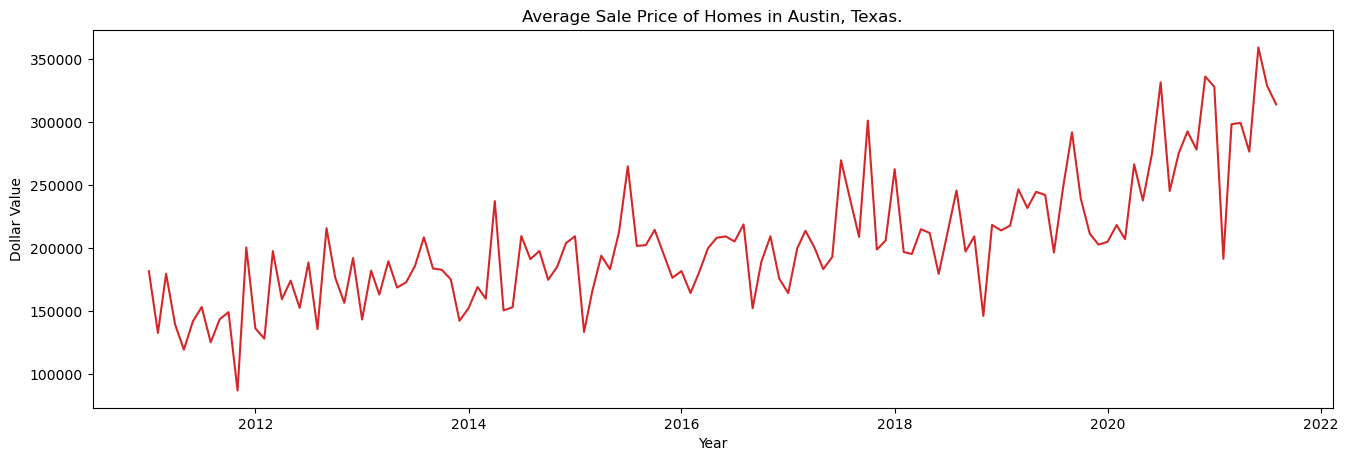

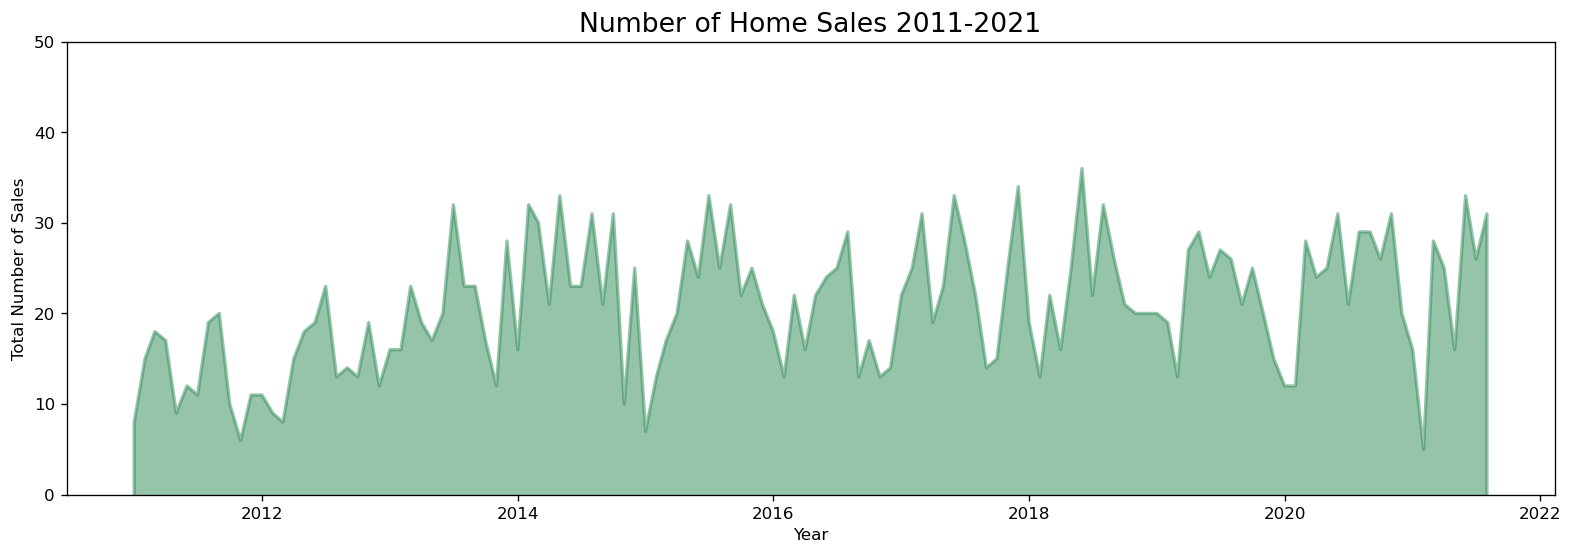

In [431]:
## modeling variances of average home prices
## pull out county consisting of high variance
vvv = df[df['county'] == 'Austin']

## Prepare data
vvv['year'] = [d.year for d in vvv.date]
vvv['month'] = [d.strftime('%b') for d in vvv.date]
years = vvv['year'].unique()

## basic time series plot
def plot_df(df, x, y, title="", xlabel='Year', ylabel='Dollar Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel='Dollar Value')
    plt.show()

plot_df(df, x=vvv.date, y=vvv.avg_price, title='Average Sale Price of Homes in Austin, Texas.') 

## Explore growth of home sales over past decade
x = vvv['date'].values
y1 = vvv['sales'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(0, 50); plt.ylabel('Total Number of Sales'); plt.xlabel('Year')
plt.title('Number of Home Sales 2011-2021', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()


# Introduction to Time Series
Additive time series: Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series: Value = Base Level x Trend x Seasonality x Error

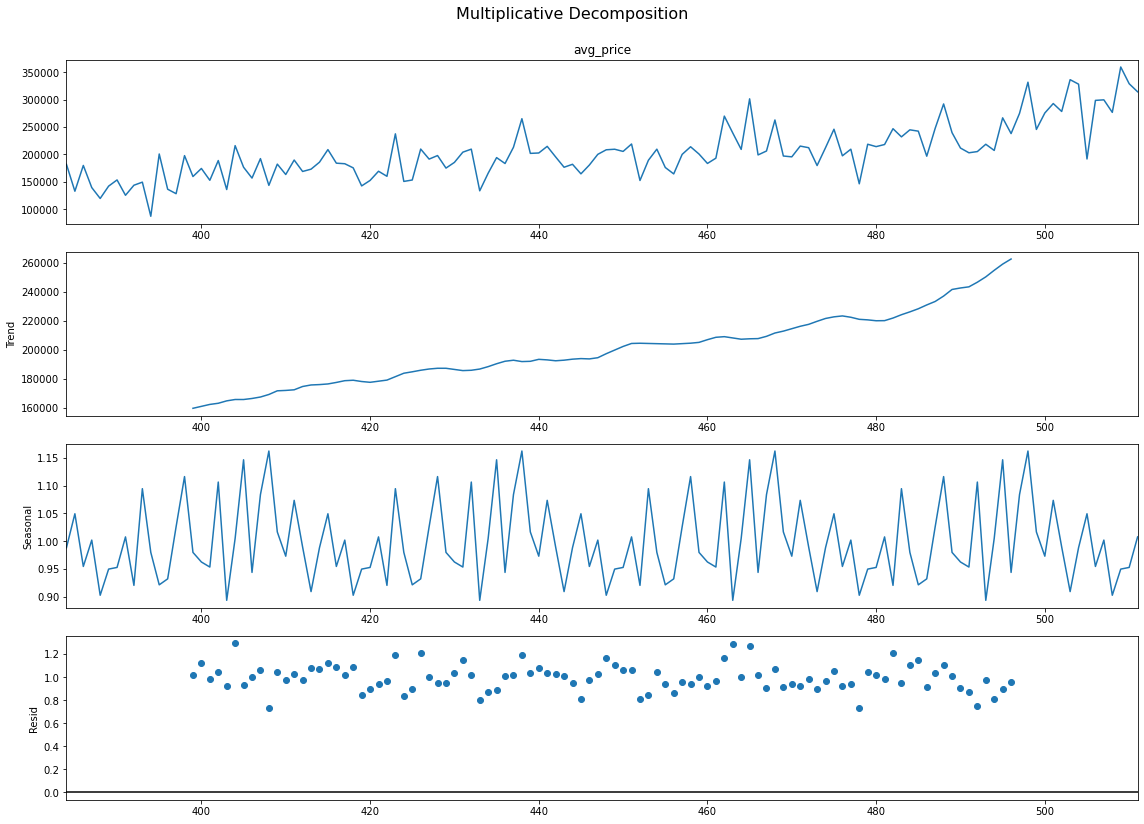

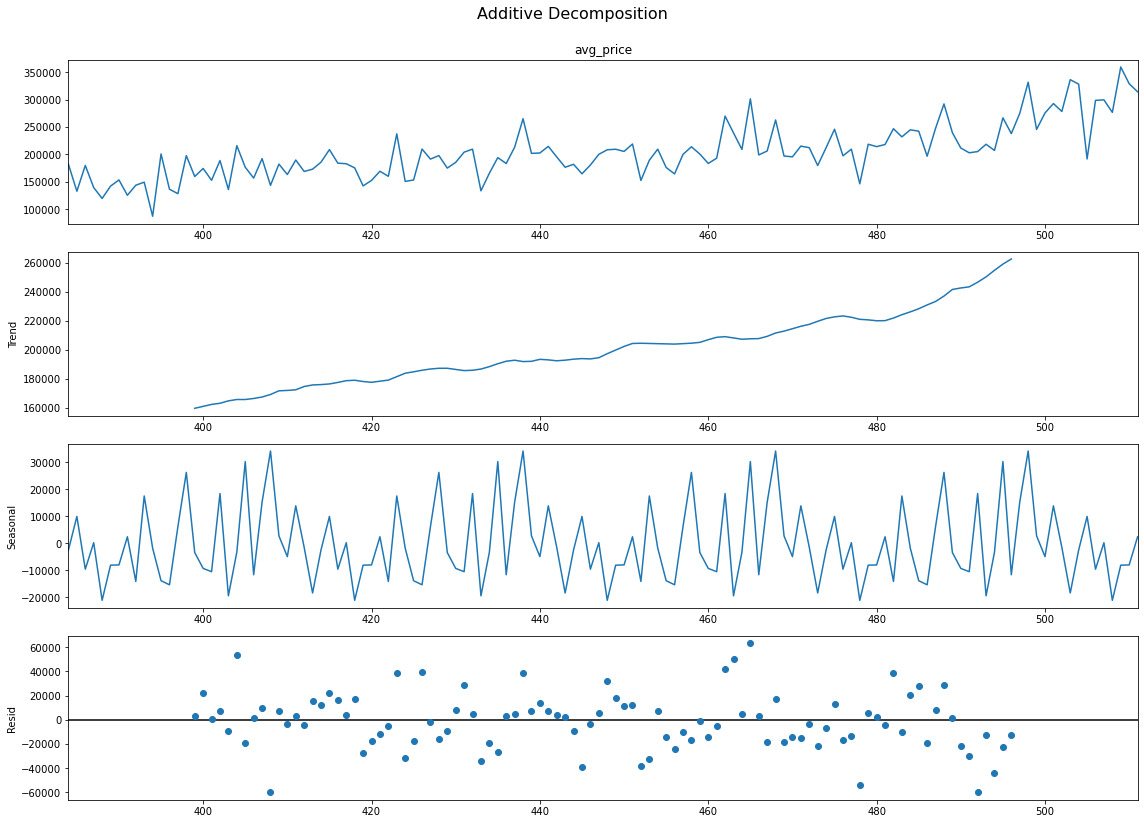

In [432]:
## Decomposition of Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(vvv['avg_price'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(vvv['avg_price'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

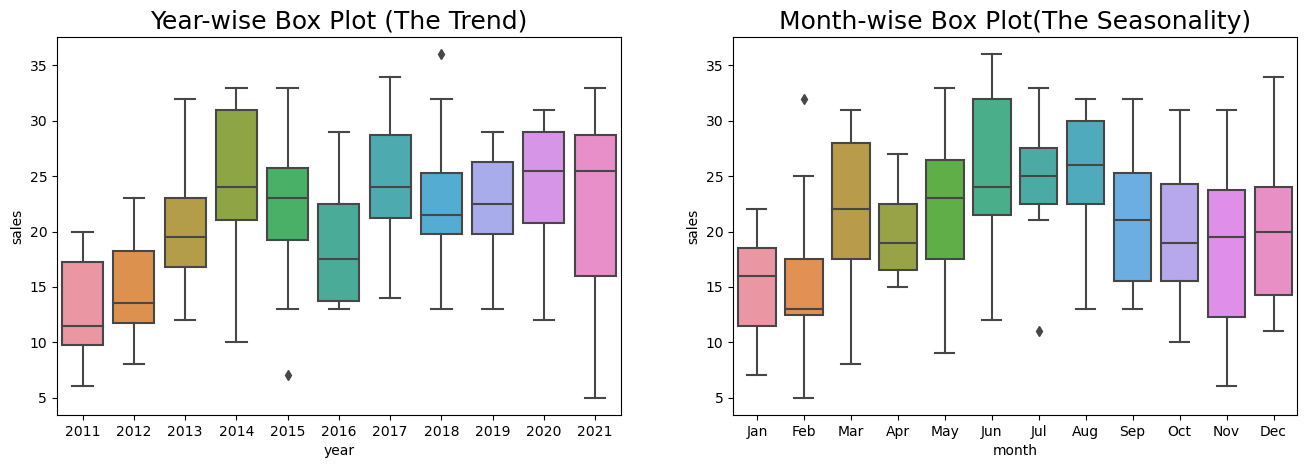

In [433]:
## Boxplots for Seasonality trend 
fig, axes = plt.subplots(1,2,figsize=(16,5), dpi= 100)
sns.boxplot(x='year', y= 'sales', data=vvv, ax=axes[0])
sns.boxplot(x='month', y='sales', data=vvv.loc[~vvv.year.isin([1991, 2008]), :])

## plot title & options
axes[0].set_title('Year-wise Box Plot (The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot(The Seasonality)', fontsize=18)
plt.show()

In [470]:
## predefine features & labels
features = ['dollar_vol','avg_price','med_price','total_listings','month_inventory']
target = ['sales']

## normalize data as there is a large absolute difference between many of the predcitors which will result in 
## disproportionally large weights for some of the covariates 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#normalizing dataframe
minmax = MinMaxScaler()
df[features] = minmax.fit_transform(df[features])


In [473]:
## split into training & testing for Time series methods
## test = ~20% of data consisting most recent dates, train = all other data
#df.dropna()
df = df.sort_values(by=['date'])
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2)
train = df.head(6558)
test = df.tail(730)

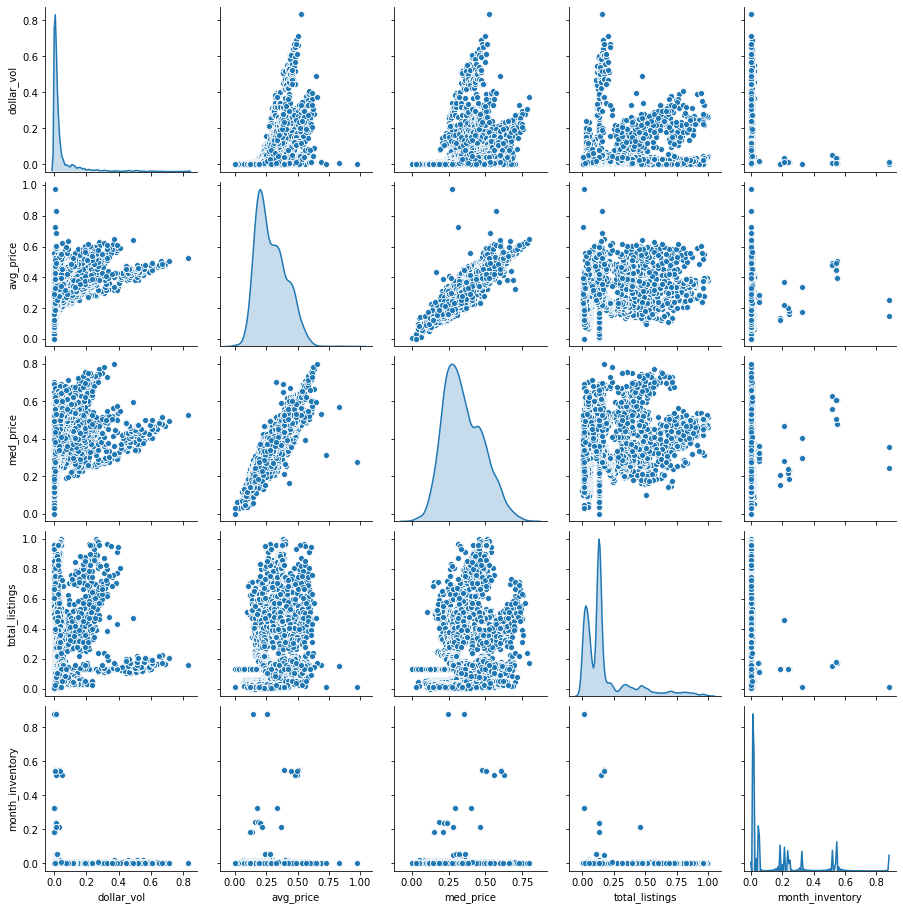

In [474]:
## basic exploratory plots
import seaborn as sns
# Draw Plot
sns.pairplot(train[features], diag_kind = 'kde')

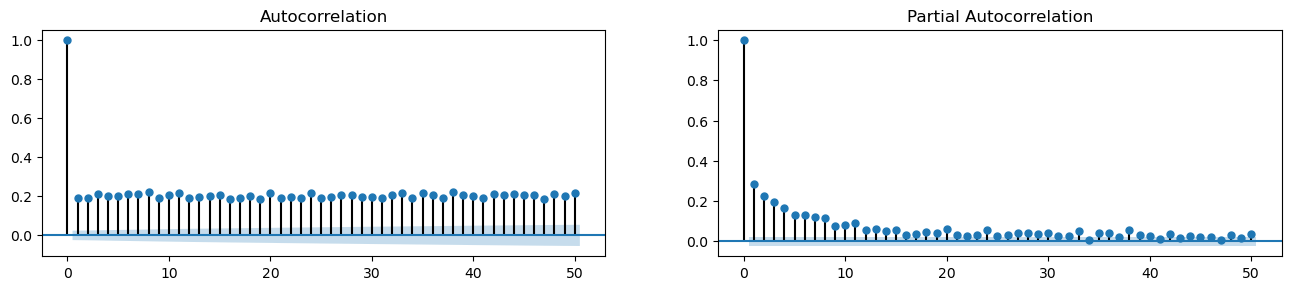

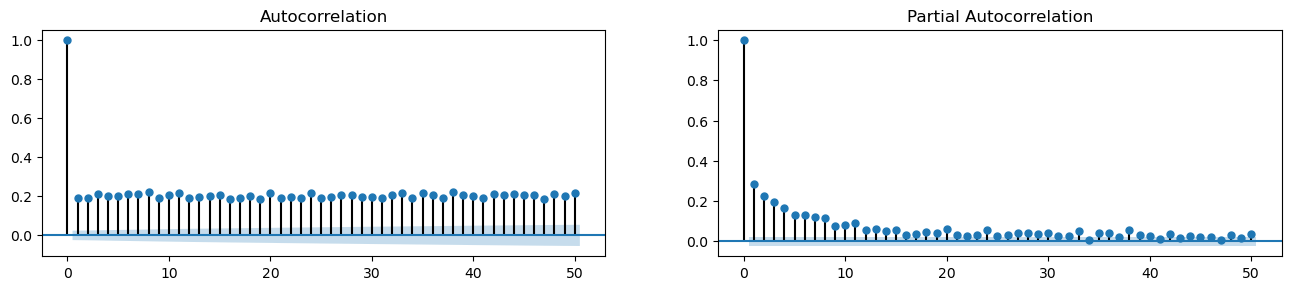

In [475]:
## autocorrelation plots
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train['avg_price'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['avg_price'].tolist(), lags=50, ax=axes[1])

# Models

## Rolling & Recursive-Rolling Regression 
**Rolling Regressions** are one of the simplest models for analysing changing relationships among variables overtime. They use linear regression but allow the data set used to change over time. In most linear regression models, parameters are assumed to be time-invariant and thus should not change overtime. Rolling regressions estimate model parameters using a fixed window of time over the entire data set. A larger sample size, or window, used will result in fewer parameter estimates but use more observations. 

**Recursive Rolling Regression**; A rolling regression with an expanding (rather than moving) window is effectively a recursive least squares model. We start with our desired window size, and add data as we expand outwards; usually capture the whole dataset 

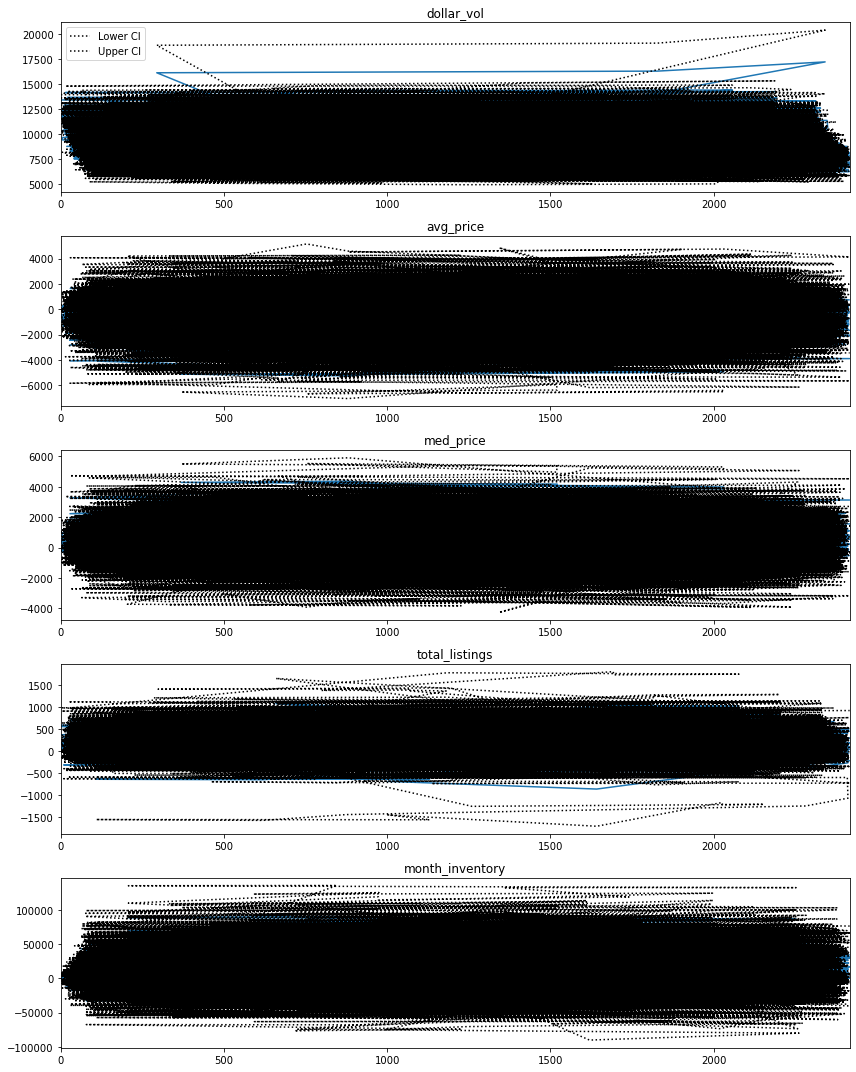

In [549]:
## Rolling regression with differing window sizes
from statsmodels.regression.rolling import RollingOLS
from statsmodels.datasets import longley
import statsmodels.api as sm

## '-1' argument supresses model estimate for intercept
roll_reg = RollingOLS.from_formula('sales ~ dollar_vol + avg_price  + med_price + total_listings + month_inventory -1', 
    window = 24, data = train) 

model = roll_reg.fit()


## plot of how our estimates vary over time
fig = model.plot_recursive_coefficient( alpha = 0.05 ,figsize = (12, 15))

Text(0.5, 1.0, 'Coefficient value')

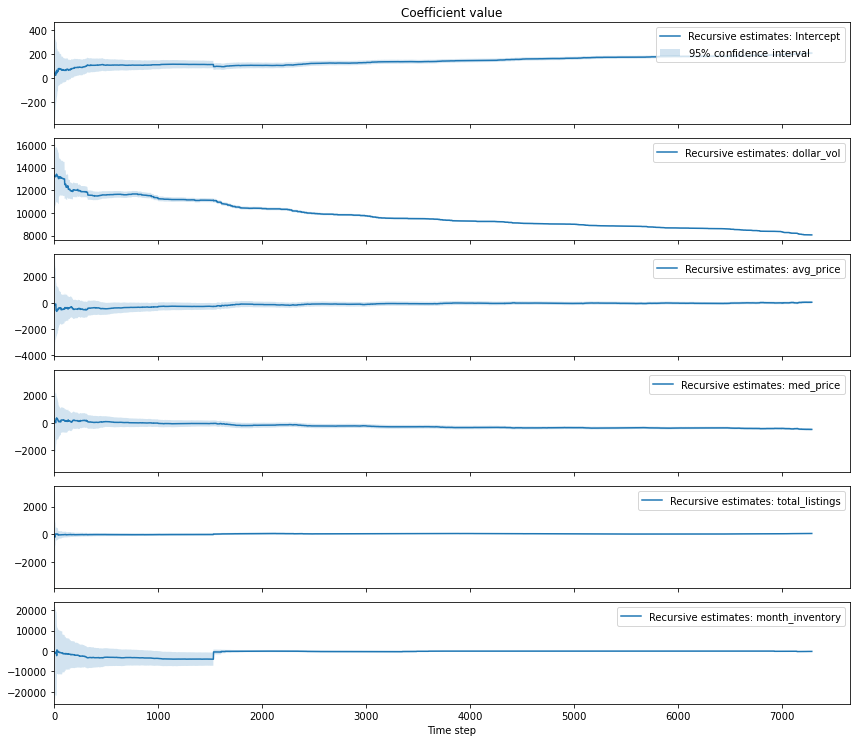

In [543]:
## Recursive ordinary least squares (expanding window rolling regression)
reg_rls = sm.RecursiveLS.from_formula(
    'sales ~ dollar_vol + avg_price + med_price + total_listings + month_inventory', df)
model_rls = reg_rls.fit()
#print(model_rls.summary())

fig = model_rls.plot_recursive_coefficient(range(reg_rls.k_exog), legend_loc='upper right', figsize = (12,10))
ax_list = fig.axes
for ax in ax_list:
    ax.set_xlim(0, None)
ax_list[-1].set_xlabel('Time step')
ax_list[0].set_title('Coefficient value')

## ARIMA Model
Next, we will be impleneting an **ARIMA model** for sales number prediction; the parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average. Set this to 12 to try & account for cyclical 12-month cycle of home prices

How do we decide these variables? This requires deeper exploration into 

(-0.25, 0.25)

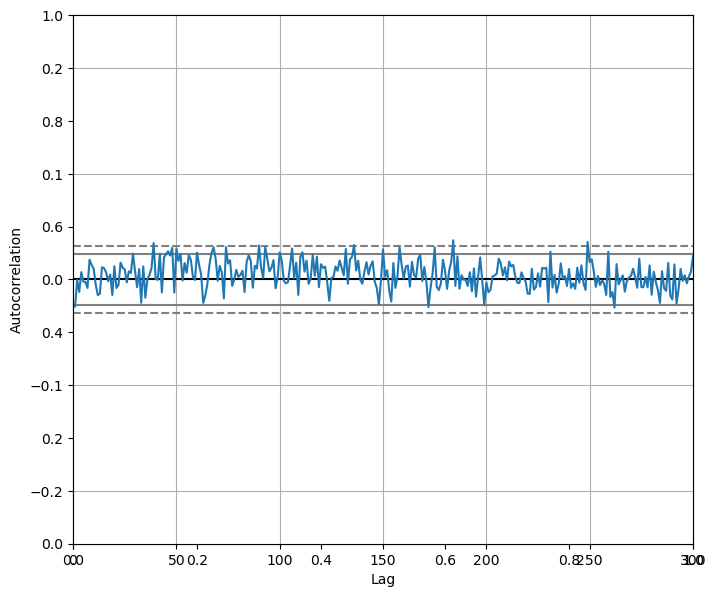

In [513]:
## making Time series
test = train[['date','sales']]
data = np.array(test['sales'])

fig, axes = plt.subplots(figsize=(8,7), dpi= 100)
## Creating Autocorrelation plot fpr sales & lag variable
x = pd.plotting.autocorrelation_plot(data)
x.set_xlim([0, 300]); x.set_ylim(-0.25,0.25)

In [534]:
## ARIMA(Autoregressive Integrated Moving Average) implementation
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## fitting ARIMA model with paramters 1,1,0
model = ARIMA(data, order=(1,1,0))
model_fit = model.fit()
#print(model_fit.summary())
model_fit.predict

<bound method ARIMAResults.predict of <statsmodels.tsa.arima_model.ARIMAResultsWrapper object at 0x7fad69d6de80>>

## Generalized Additive Models

If the data is having a nonlinear effect, in such a case we use GAM. Linearity in models means that the changes of one unit in predictors can cause the same effect on the outcome of the model. If at some point, changes in feature not affecting the outcome or impacting oppositely, we can say that there is a nonlinearity effect in the data.

For this section, we will explore the possibiltiy that the some of the relationships between our response & predictors follow a nonlinear relationship.


In [479]:
## Generalized Additive Models (GAM)
## Generalized Additive Models allow for penalized estimation of smooth terms in generalized linear models
from pygam import LinearGAM, s, f
from pandas.plotting import autocorrelation_plot


## On the Practicality of Neural Nets for Time Series Regression

Our estimators here vary wildly in terms of weights - I suspect a variation of neural nets to be able to acquire better weight estiamtes for these coefficients


## Basic NN with One Covariate

In [482]:
## basic NN with one covariate(avg_price)
avg = np.array(X_train['avg_price'])

sales_normalizer = layers.Normalization(input_shape=[1,], axis=None)
sales_normalizer.adapt(avg)
sales_model = tf.keras.Sequential([
    sales_normalizer,
    layers.Dense(units=1)
])
sales_model.summary()

#make predictions
sales_model.predict(avg[:10])

sales_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [527]:
history = sales_model.fit(
    X_train['avg_price'],
    X_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,0.158952,0.156639,95
96,0.157816,0.154384,96
97,0.158209,0.153426,97
98,0.157621,0.153770,98
99,0.158386,0.155530,99


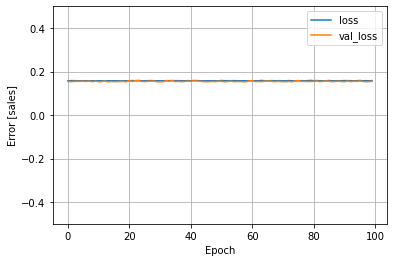

In [528]:
## squared error loss over epochs
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([-0.5, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [sales]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## NN with Multiple Covaraites

In [529]:
## NN Linear Regression w/ Multiple Inputs
normalizer = tf.keras.layers.Normalization(axis=-1)

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(X_train[:10])

linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

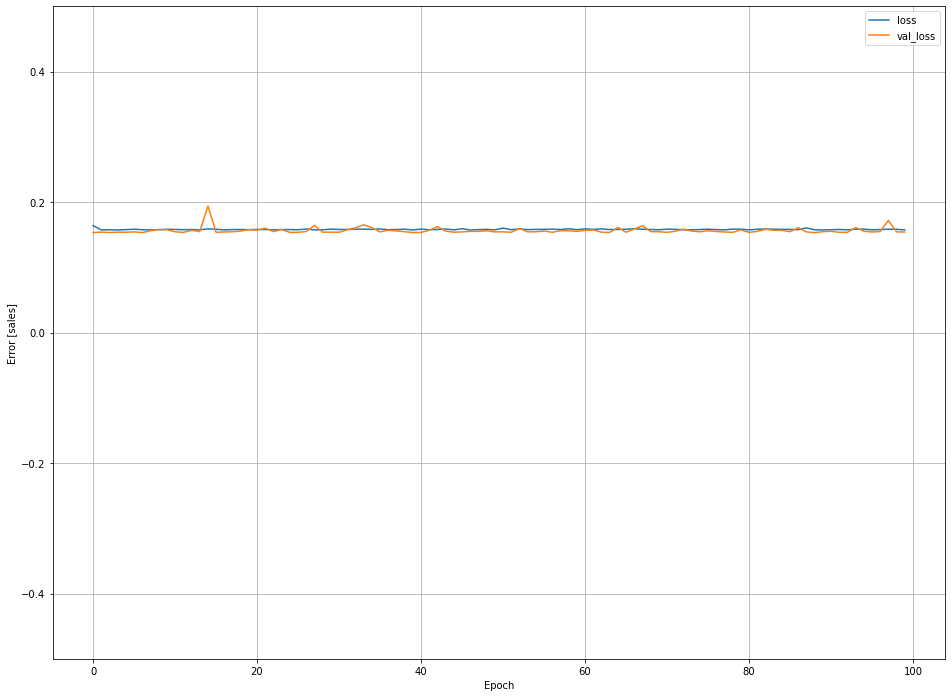

In [495]:
history = linear_model.fit(
    X_train['avg_price'],
    X_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
    
plot_loss(history)

## Deep Neural Nets

In [530]:
## Deep Neural Net
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

  

## Bayesian Neural Net

Bayesian Neural Nets

# Findings & Discussion

## Findings

Now that

## Discussion

For further research, one may imagine the incorporation of Monte-Carlo based supervised learning methods which would allow for greater averages & estimations over large datasets. For this specific issue, we ran into 


# Conclusion

## References